# <center>Universidade Federal de Minas Gerais</center>
## <center>Departamento de Ciência da Computação</center>
### <center>Projeto final: Predizendo a área do conhecimento de teses e dissertações dos programas de pós-graduação do Brasil </center>
<center>Ewerton Silva Santos.</center>
<center>Matricula: 2016058140.</center>
<center>ewerton_dc@hotmail.com</center>
<center>02 de Setembro de 2021</center>

**Resumo**: objetivo é criar um modelo Sequence-to-Sequence usando uma rede LSTM, o qual que preveja a grande área de concentração de teses e dissertações por meio do resumo informado pelo autor. O corpus está disponível em https://dadosabertos.capes.gov.br/dataset/2018-catalogo-de-teses-e-dissertacoes-da-capes. 

**Sobre o Dataset**: "Os dados contêm informações sobre as Teses e Dissertações da Pós-Graduação de 2017 a 2019 consolidados a partir do COLETA CAPES, os nomes dos autores, a data de defesa, a localização da IES a qual o autor está vinculado, a área de conhecimento da tese ou dissertação. No ano de 2017 temos 83.281 registros com 83.262 autores distintos dos 3.954 Programas de Pós-Graduação de 415 IES. No ano de 2018 temos 88.120 registros com 88.093 autores distintos dos 4.151 Programas de Pós-Graduação de 434 IES. No ano de 2019 temos 93.692 registros com 93.656 autores distintos dos 4.250 Programas de Pós-Graduação de 451 IES." [SIC]

**Baixar do GitHub**: https://github.com/EwertonDCSilv/ml_final_project

**Executar no colab**: https://drive.google.com/drive/folders/1ICIJ_xPF-vBWPcNce7o4J3PZdaWzjTPM?usp=sharing

**Link do vídeo no Drive** https://drive.google.com/file/d/1ofNnDHdGxzrcbO0ajImCfr8caJ78ZPnt/view?usp=sharing

**Link do vídeo no YouTube** https://youtu.be/j2sgVNEoXc0


------

# 1 - Introdução
<div style="text-align: justify!important"> 
<p>O processo de classificação automática de texto pode ser útil para diversos tipos de aplicação, é uma atividade que se tornou extremamente importante para oranizações e usuários comuns. Este tipo de classificação pode ser utilizado para tarefas de analise de sentimentos, modelagem de tópicos, classificação de spam, verificação de notícias falsas, transcrição de áudio em texto, dentre tantas aplicações. Neste trabalho iremos tratar da predição da grande área de concentração por meio do resumo fornecido a "Coordenação de Aperfeiçoamento de Pessoal de Nível Superior"(CAPES), utilizando-se da vetorização dos elementos textuais e suas características, para assim predizer a grande área do conhecimento (cincias agrrias, cincias biolgicas, cincias da sade, cincias exatas e da terra, cincias humanas, etc). O modelo escolhido para realizar esta tarefa foi Rede Neural Recorrente (RNN) usando a arquitetura Long Short Term Memory (LSTM), sendo utilizado o dataset catalogo-de-teses-e-dissertacoes-brasil-2017-2019, tanto para treino quanto para teste.</p>

<p>O modelo LSTM foi escolhido tento em vista sua alta capacidade de predição, fato devido principalmente a sua estrutura que permite a memorização do texto e o seu respectivo esquecimento. Além disso, o modelo permite modelar de forma simples a dependência entre os termos</p>

<p>Dada a o tratamento dos dados, a implementação do modelo, serão avaliadas, melhores escolhas de parâmetros, precisão da classificação dos produtos no geral e em especifico.</p>
</div>

In [ ]:
!  pip install imbalanced-learn

In [ ]:
# General
import os
import re
import nltk
import pickle
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from imblearn.under_sampling import RandomUnderSampler

# Stemming
from nltk.stem import PorterStemmer, SnowballStemmer

# Scikit
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Dense, Embedding, LSTM, SpatialDropout1D
from IPython.display import Image 
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk import word_tokenize

# TensorFlow
from tensorflow import keras

# Graficos
%matplotlib inline
plt.rcParams['figure.figsize']  = (10, 8)
plt.rcParams['axes.labelsize']  = 12
plt.rcParams['axes.titlesize']  = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [ ]:
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 10)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Parametros gerais e configurações

In [ ]:
"""
  Definições gerais
"""
# Caminho para pasta com dados
homePath = "drive/MyDrive/ML/"

# Baixnado conjunto de stopwords
nltk.download("stopwords")

#Expressões regulares para tratamento de texto
caracterToSpace = re.compile('[/(){}\[\]\|@,;]') 
especialCacracters = re.compile('[^0-9a-z #+_]')
stopWords = set(stopwords.words('portuguese'))

# Comprimento do texto
dimensionEmbed = 100 # Dimensão do embedding
maxWords = 50000     # Numero de palavras mais frequentes a serem utilizadas
maxSequence = 250    # Comprimento maximo da sequencia

# Parametros do modelo
epochs = 5
batch_size = 64

# Flag de treinamento
bool_train = True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Obtendo dataset
Dataset contendo catalogo de teses e dissertações do programas de pós-graduação da CAPES. O dataset
 está disponível em https://catalog.data.gov/dataset/consumer-complaint-database.

In [ ]:
# Dataset origim https://www.kaggle.com/sebastienverpile/consumercomplaintsdata/home
df = pd.read_csv(os.path.join(homePath,'data/catalogo-de-teses-e-dissertacoes-brasil-2017-2019.csv'), sep=';', low_memory=False)

# Shape do dataset
print(df.shape)

# Exemplo com dados brutos
df.head()

(265094, 56)


,ano_base,codigo_programa,nome_programa,sigla_ies,nome_ies,id_add_producao_intelectual,id_producao_intelectual,titulo_tese,id_subtipo_producao,nome_subtipo_producao,id_area_concentracao,nome_area_concentracao,id_linha_pesquisa,linha_pesquisa,id_projeto,nome_projeto,dh_inicio_area_conc,dh_fim_area_conc,dh_inicio_linha,dh_fim_linha,data_defesa,ds_palavra_chave,descricao_abstract,descricao_keyword,in_trabalho_mesma_area,nome_tp_vinculo,in_orient_participou_banca,biblioteca_depositaria,id_tp_expectativa_atuacao,nome_expectativa_atuacao,id_pessoa_discente,nome_discente,data_matricula,id_grau_academico,nome_grau_academico,nome_orientador,descricao_categoria_orientador,nome_categoria_docente,regiao,uf,nome_uf_ies,grande_area_codigo,grande_area_descricao,area_conhecimento_codigo,area_conhecimento,codigo_subarea_conhecimento,nome_subarea_conhecimento,codigo_especialidade,nome_especialidade,area_avaliacao,volume,numero_paginas,idioma,ds_resumo,url_texto_completo,id_pessoa_orientador
0,2017.0,32002017008P8,EXTENSï¿½O RURAL,UFV,UNIVERSIDADE FEDERAL DE VIï¿½OSA,22209000.0,6192151.0,INDICADORES DE AVALIAï¿½ï¿½O DE DESEMPENHO DE ...,2.0,DISSERTAï¿½ï¿½O,78116.0,INSTITUIï¿½ï¿½ES SOCIAIS E DESENVOLVIMENTO,88320.0,COMUNICAï¿½ï¿½O E PROCESSOS COOPERATIVOS,399984.0,INDICADORES DE AVALIAï¿½ï¿½O DE DESEMPENHO DE ...,01/01/2012 00:00,NaN,01/01/2012 00:00,NaN,08Dec2017 0:00:00,INDICADORES DE DESEMPENHO;COOPERATIVAS AGROPEC...,THE PRESENT RESEARCH WAS CARRIED OUT WITH THE ...,PERFORMANCE INDICATORS;AGRICULTURAL COOPERATIV...,1.0,SERVIDOR Pï¿½BLICO,1.0,UFV,1.0,ENSINO E PESQUISA,2310655.0,JOSE ANTONIO BRILHANTE DE SAO JOSE,03Aug2015 0:00:00,27.0,MESTRADO,MARCELO JOSE BRAGA,DOCENTE,PERMANENTE,SUDESTE,MG,MINAS GERAIS,50000004.0,CIï¿½NCIAS AGRï¿½RIAS,50100009.0,AGRONOMIA,50106007,EXTENSï¿½O RURAL,NI,Nï¿½O INFORMADO,CIï¿½NCIAS AGRï¿½RIAS I,1,76.0,PORTUGUES,A PRESENTE PESQUISA FOI REALIZADA COM O OBJETI...,https://sucupira.capes.gov.br/sucupira/public/...,7345.0
1,2017.0,33014019003P3,ADMINISTRAï¿½ï¿½O Pï¿½BLICA E GOVERNO,FGV/SP,FUNDAï¿½ï¿½O GETï¿½LIO VARGAS (SP),22069270.0,6030533.0,ESTA TESE REALIZA UM ESTUDO EMPï¿½RICO SOBRE O...,1.0,TESE,82183.0,ADMINISTRAï¿½ï¿½O Pï¿½BLICA,105426.0,ADMINISTRAï¿½ï¿½O Pï¿½BLICA E GOVERNO ï¿½ DINT...,NaN,NaN,01/01/2012 00:00,NaN,01/01/2013 00:00,NaN,01/06/2017 00:00,CICLO ORï¿½AMENTï¿½RIO;ORï¿½AMENTO Pï¿½BLICO;S...,THIS THESIS MAKES AN EMPIRICAL STUDY ABOUT THE...,BUDGET CYCLE;PUBLIC BUDGET;HEALTH SECTOR.,1.0,CLT,1.0,BIBLIOTECA KARL A BOEDECKER,1.0,ENSINO E PESQUISA,410839.0,ROBERTO RIVELINO MARTINS RIBEIRO,15Aug2013 0:00:00,28.0,DOUTORADO,NELSON MARCONI,DOCENTE,PERMANENTE,SUDESTE,SP,Sï¿½O PAULO,60000007.0,CIï¿½NCIAS SOCIAIS APLICADAS,60200006.0,ADMINISTRAï¿½ï¿½O,NI,Nï¿½O INFORMADO,NI,Nï¿½O INFORMADO,"ADMINISTRAï¿½ï¿½O Pï¿½BLICA E DE EMPRESAS, CIï...",1,141.0,PORTUGUES,ESTA TESE REALIZA UM ESTUDO EMPï¿½RICO SOBRE O...,https://sucupira.capes.gov.br/sucupira/public/...,27846.0
2,2017.0,40001016003P2,CIï¿½NCIAS (BIOQUï¿½MICA),UFPR,UNIVERSIDADE FEDERAL DO PARANï¿½,22472555.0,5003119.0,ATIVIDADES ANTICOAGULANTE E ANTITROMBï¿½TICA D...,1.0,TESE,83021.0,BIOQUï¿½MICA,96255.0,QUï¿½MICA DE CARBOIDRATOS,197102.0,"CARACTERIZAï¿½ï¿½O ESTRUTURAL, PROPRIEDADES Fï...",01/01/2014 00:00,NaN,01/01/2014 00:00,NaN,23Feb2017 0:00:00,POLISSACARï¿½DEO SULFATADO;POLISSACARï¿½DEO FO...,"IN THIS THESIS, RESULTS OF CHEMICAL SULFATION ...",SULFATED POLYSACCHARIDE;PHOSPHORYLATED POLYSAC...,0.0,Nï¿½O INFORMADO,1.0,BIBLIOTECA CENTRAL UFPR,0.0,Nï¿½O INFORMADO,835556.0,YONY ROMAN OCHOA,05/03/2013 00:00,28.0,DOUTORADO,THALES RICARDO CIPRIANI,DOCENTE,PERMANENTE,SUL,PR,PARANï¿½,20000006.0,CIï¿½NCIAS BIOLï¿½GICAS,20800002.0,BIOQUï¿½MICA,NI,Nï¿½O INFORMADO,NI,Nï¿½O INFORMADO,CIï¿½NCIAS BIOLï¿½GICAS II,1,186.0,PORTUGUES,NESTA TESE Sï¿½O APRESENTADOS RESULTADOS DE SU...,https://sucupira.capes.gov.br/sucupira/public/...,92715.0
3,2017.0,40001016003P2,CIï¿½NCIAS (BIOQUï¿½MICA),UFPR,UNIVERSIDADE FEDERAL DO PARANï¿½,22472556.0,4994982.0,AVALIAï¿½ï¿½O DA ESTRUTURA QUï¿½

In [ ]:
df['ds_resumo'] = [str(resume).encode("ascii", "ignore").decode('utf-8').lower().replace(";", " ") for resume in df['ds_resumo']]
df['titulo_tese'] = [str(resume).encode("ascii", "ignore").decode('utf-8').lower().replace(";", " ") for resume in df['titulo_tese']]
df['descricao_keyword'] = [str(resume).encode("ascii", "ignore").decode('utf-8').lower().replace(";", " ") for resume in df['descricao_keyword']]
df['grande_area_descricao'] = [str(area).encode("ascii", "ignore").decode('utf-8').lower() for area in df['grande_area_descricao']]
df['description'] = [" ".join(resume) for resume in df[['titulo_tese', 'descricao_keyword']].values]
df[['grande_area_descricao','description','titulo_tese','descricao_keyword','ds_resumo','numero_paginas','idioma']].head()

,grande_area_descricao,description,titulo_tese,descricao_keyword,ds_resumo,numero_paginas,idioma
0,cincias agrrias,indicadores de avaliao de desempenho de cooper...,indicadores de avaliao de desempenho de cooper...,performance indicators agricultural cooperativ...,a presente pesquisa foi realizada com o objeti...,76.0,PORTUGUES
1,cincias sociais aplicadas,esta tese realiza um estudo emprico sobre o ci...,esta tese realiza um estudo emprico sobre o ci...,budget cycle public budget health sector.,esta tese realiza um estudo emprico sobre o ci...,141.0,PORTUGUES
2,cincias biolgicas,atividades anticoagulante e antitrombtica de p...,atividades anticoagulante e antitrombtica de p...,sulfated polysaccharide phosphorylated polysac...,nesta tese so apresentados resultados de sulfa...,186.0,PORTUGUES
3,cincias biolgicas,avaliao da estrutura qumica e atividades biolg...,avaliao da estrutura qumica e atividades biolg...,arrabidaea chica croton cajucara polysaccharid...,arrabidaea chica v. (crajiru) comum da regio ...,165.0,PORTUGUES
4,cincias da sade,o processo de trabalho na estratgia sade da fa...,o processo de trabalho na estratgia sade da fa...,"primary health care, family health strategy, p...",apesar do sucesso no desenvolvimento de medica...,90.0,PORTUGUES


In [ ]:
df['ds_resumo_old'] = df['ds_resumo']
df['ds_resumo'] = df['description']

### Recortando dataset
Para realizar a tarefa de predição serão utilizadas apenas as colunas "grande_area_descricao" (referente a grande área do trabalho), "ds_resumo" (referente ao resumo do trabalho). 

In [ ]:
# Recortando colunas do dataframe
cutColumns = ['grande_area_descricao','ds_resumo']
df = df.query("idioma == 'PORTUGUES'")
df = df.query('ds_resumo != ""')
df = df.query('numero_paginas != 0')
df = df[cutColumns]

# Removendo linhas com entradas nulas
df = df.dropna()

# Shape do dataset
print(df.shape)

df.head()

(222572, 2)


,grande_area_descricao,ds_resumo
0,cincias agrrias,indicadores de avaliao de desempenho de cooper...
1,cincias sociais aplicadas,esta tese realiza um estudo emprico sobre o ci...
2,cincias biolgicas,atividades anticoagulante e antitrombtica de p...
3,cincias biolgicas,avaliao da estrutura qumica e atividades biolg...
4,cincias da sade,o processo de trabalho na estratgia sade da fa...


### Teses e dissertações por grande área do conhecimento

In [ ]:
# Ocorrencias por tipo de produto
df.groupby("grande_area_descricao",as_index=None).count()

,grande_area_descricao,ds_resumo
0,cincias agrrias,20336
1,cincias biolgicas,12546
2,cincias da sade,35142
3,cincias exatas e da terra,16162
4,cincias humanas,36963
5,cincias sociais aplicadas,33296
6,engenharias,23952
7,"lingstica, letras e artes",13544
8,multidisciplinar,30631


# 2 - Implementação
O modelo é treinado e validado utilizando apenas parte dos atributos do dataset, neste caso apenas as reclamações textuais(string) a categoria do produto (variável categórica). O dataset apresenta 9 categorias. Outro tratamento realizado é a remoção de linhas nulas, havendo originalmente **265 mil linhas**, que se reduzem a **222 mil**. Em seguida o texto livre é sanitizado, removendo caracteres especiais e stop words, para adiante ser separado em tokens, que em seguida são convertidos para um embedding vetorial da biblioteca ***Keras***, a qual também é utilizada para criação do modelo de predição. Por fim, os dados são separados em 30% para treino e 70% para teste, havendo uma ordenação aleatória das entradas.

### Tratando dados: removendo caracteres especiais e stop words

In [ ]:
# Define stemmer
stemmer_ps = PorterStemmer() 
stemmer_sn = SnowballStemmer("portuguese")

In [ ]:
def sanitazeText(sentence):
    sentence = sentence.lower()                                                     # Tudo minusculo
    sentence = sentence.strip()                                                     # Remove espacos nas extremidades das strings
    sentence = caracterToSpace.sub(' ', sentence)                                   # Remove carcteres por espaco
    sentence = especialCacracters.sub('', sentence)                                 # Remove caracteres 
    sentence = sentence.replace('x', '')                                            # Remove X caracteres que ocultam dados pessoais 
    sentence = ' '.join(stemmer_ps.stem(word) for word in sentence.split() if word not in stopWords) # Removendo stop words
    return sentence

In [ ]:
# Exemplo de dado sem tratamento
print("****************************** Antes: ****************************** ")
print("Resumo:",df[["ds_resumo","grande_area_descricao"]].values[100][0],end='\n\n')
print("Area do conhecimento:", df[["ds_resumo","grande_area_descricao"]].values[100][1])
print("*******************:\n\n")

# Aplicando funcao de limpeza de string sobre a coluna textual
df['ds_resumo'] = df['ds_resumo'].apply(sanitazeText)
df['ds_resumo'] = df['ds_resumo'].str.replace('\d+', '')

# Exemplo de dado apos tratamento
print("****************************** Depois: ****************************** ")
print("Resumo: ",df[["ds_resumo","grande_area_descricao"]].values[100][0])
print("Area do conhecimento: ", df[["ds_resumo","grande_area_descricao"]].values[100][1],end="\n\n")

****************************** Antes: ****************************** 
Resumo: avaliao da segurana teraputica do formol em larvas e juvenis de pacams lophiosilusrus alexandri. formalin, toxicity, native fish, siluriform.

Area do conhecimento: cincias agrrias
*******************:


****************************** Depois: ****************************** 
Resumo:  avaliao segurana teraputica formol larva juveni pacam lophiosilusru aleandri formalin toiciti nativ fish siluriform
Area do conhecimento:  cincias agrrias



### Embeding

In [ ]:
# Tranformando palavras em Tokens
tokenizer = Tokenizer(num_words=maxWords, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['ds_resumo'].values)
word_index = tokenizer.word_index
print('Numero de tokens distintos: ', len(word_index))

Numero de tokens distintos:  163239


### Dividindo dados de treino e teste


In [ ]:
# Seprando dados
rus = RandomUnderSampler()
X = tokenizer.texts_to_sequences(df['ds_resumo'].values)
X = pad_sequences(X, maxlen=maxSequence)

# Seprando labels
Y = pd.get_dummies(df['grande_area_descricao']).values
numberClasses = len(set(df['grande_area_descricao']))

# Separando dados de Treino e Teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size = 0.30, shuffle=True, random_state = 42)
X_res, Y_res = rus.fit_sample(X_train, Y_train)

print('Dimensões do vetor de dados:', X.shape)
print('Dimensões do vetor de labels:', Y.shape)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Dimensões do vetor de dados: (222572, 250)
Dimensões do vetor de labels: (222572, 9)
(155800, 250) (155800, 9)
(66772, 250) (66772, 9)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Distribuição dos dados apos a divisão: Treino

,grande_area_descricao,valoes
cincias agrrias,0,14235
cincias biolgicas,1,8782
cincias da sade,2,24599
cincias exatas e da terra,3,11314
cincias humanas,4,25874
cincias sociais aplicadas,5,23307
engenharias,6,16766
"lingstica, letras e artes",7,9481
multidisciplinar,8,21442


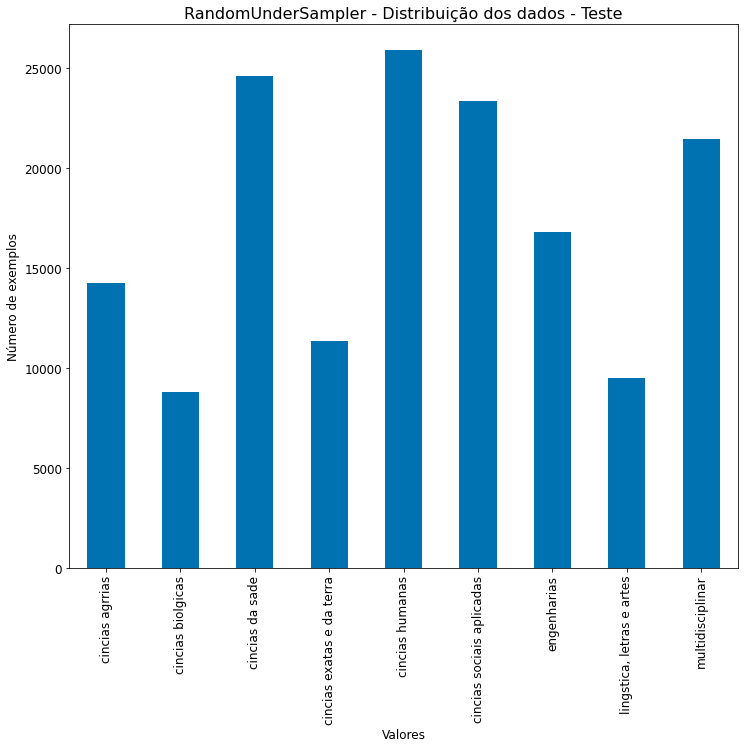

In [ ]:
# Agrupamento
valores = sorted(df['grande_area_descricao'].unique())

# UnDummy
df_treino = pd.DataFrame(data=Y_train)
unDummy = df_treino.idxmax(axis=1)
df_treino = pd.DataFrame(data=unDummy,  columns=['grande_area_descricao'])
df_treino['valoes'] = df_treino['grande_area_descricao']

# count
group = df_treino.groupby(['grande_area_descricao'], as_index=False).count()
group = group.set_index([valores])

# Plotando valores    
ax = group['valoes'].plot.bar()
ax.set_title("Distribuição dos dados - Teste")
ax.set_xlabel("Valores")
ax.set_ylabel("Número de exemplos")
group

### Distribuição dos dados apos a divisão: Teste

,grande_area_descricao,valoes
cincias agrrias,0,6101
cincias biolgicas,1,3764
cincias da sade,2,10543
cincias exatas e da terra,3,4848
cincias humanas,4,11089
cincias sociais aplicadas,5,9989
engenharias,6,7186
"lingstica, letras e artes",7,4063
multidisciplinar,8,9189


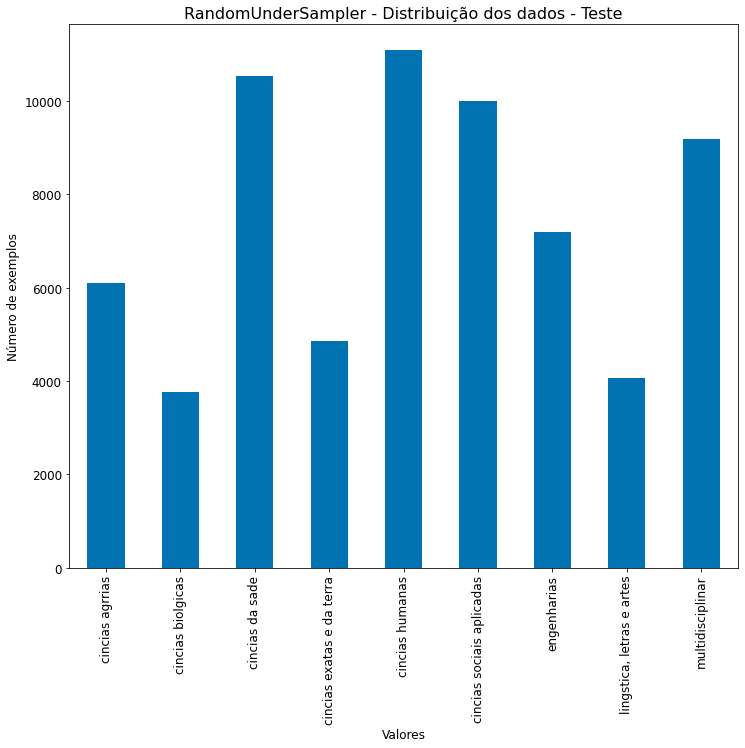

In [ ]:
# Agrupamento
valores = sorted(df['grande_area_descricao'].unique())

# UnDummy
df_test = pd.DataFrame(data=Y_test)
unDummy = df_test.idxmax(axis=1)
df_test = pd.DataFrame(data=unDummy,  columns=['grande_area_descricao'])
df_test['valoes'] = df_treino['grande_area_descricao']

# count
group = df_test.groupby(['grande_area_descricao'], as_index=False).count()
group = group.set_index([valores])

# Plotando valores    
ax = group['valoes'].plot.bar()
ax.set_title("Distribuição dos dados - Teste")
ax.set_xlabel("Valores")
ax.set_ylabel("Número de exemplos")
group

### Definindo estrutura do Modelo
O modelo de predição possui 4 camadas:
* **Embedding**: camada de entrada que tem por objetivo transformar inteiros positivos em vetores densos, tendo máximo 50 mil palavras para os vocabulários e 250 para dimensão dos dados. Entrada: tensor 2d; Saída: tensor 3d
* **SpatialDropout1D**: camada interna que promove a independência entre os mapas de características, realizando a remoção de forma aleatória de neurônios para evitar overfitting.  
* **LSTM**: camada interna que responsável pela longa memoria de curto prazo, a qual permite que os estados anteriores sejam utilizados para prever os estados futuros. 
* **Dense**: camada de saída, onde é executada a função de ativação para cada elemento. Tem dimensão de saída igual ao número de classes de produtos



In [ ]:
# Definindo modelo usando Keras
model = Sequential()
model.add(Embedding(maxWords, dimensionEmbed, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(120, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(numberClasses, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Sumarizando modelo
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 120)               106080    
_________________________________________________________________
dense (Dense)                (None, 9)                 1089      
Total params: 5,107,169
Trainable params: 5,107,169
Non-trainable params: 0
_________________________________________________________________
None


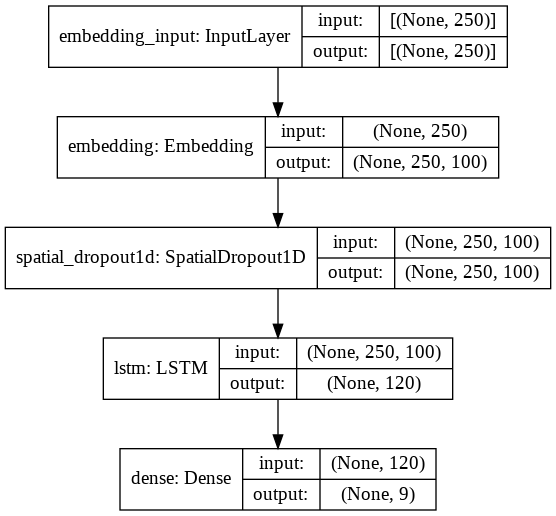

In [ ]:
# Plotando modelo
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

### Treinando modelo

In [ ]:
# Realizando treino do modelo
if bool_train is True:
  historico = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
2191/2191 [==============================] - 1839s 838ms/step - loss: 1.0514 - accuracy: 0.6272 - val_loss: 0.8796 - val_accuracy: 0.6823
Epoch 2/5
2191/2191 [==============================] - 1833s 836ms/step - loss: 0.7420 - accuracy: 0.7343 - val_loss: 0.8771 - val_accuracy: 0.6868
Epoch 3/5
2191/2191 [==============================] - 1833s 837ms/step - loss: 0.6145 - accuracy: 0.7770 - val_loss: 0.9267 - val_accuracy: 0.6787
Epoch 4/5
2191/2191 [==============================] - 1835s 837ms/step - loss: 0.5182 - accuracy: 0.8105 - val_loss: 1.0174 - val_accuracy: 0.6756
Epoch 5/5
2191/2191 [==============================] - 1836s 838ms/step - loss: 0.4418 - accuracy: 0.8375 - val_loss: 1.1179 - val_accuracy: 0.6704


### Exportando modelo treinado

In [ ]:
# Exportando modelo apenas quando o treino é realizado
if bool_train is True:
  # Exportando historico
  with open(os.path.join(homePath,'history'), 'wb') as file_pi:
      pickle.dump(historico.history, file_pi)

  model.save(os.path.join(homePath,'model/'))

### Carregando modelo ja treinado

In [ ]:
# Exportando modelo apenas quando o treino é realizado
if bool_train is False:
  model = keras.models.load_model(os.path.join(homePath,'model/'))

# 3 - Analise Experimental
<p>Após a realização do teste do modelo, obtém-se uma acurácia total de 84,07%. Abaixo são exibidos os gráficos de perda e acurácia do modelo ao longo das 5 épocas, além de uma matriz de confusão para a predição de cada classe. 
</p>
<p>Pode-se observar o aumento da acurácia e a redução da perda com o aumento do número de épocas, havendo uma leve estabilização após a 4 época durante o teste</p>

In [ ]:
# Calculando acuracia do modelo
acuracia = model.evaluate(X_test,Y_test)
print('Conjunto de teste\n Perda: {:0.3f}\nAcuracia: {:0.3f}'.format(acuracia[0],acuracia[1]))

Conjunto de teste
 Perda: 1.115
Acuracia: 0.841


In [ ]:
# Obtendo rotulos de predição para o teste
Y_pred  = model.predict(X_test)

### Teste: Perda do modelo

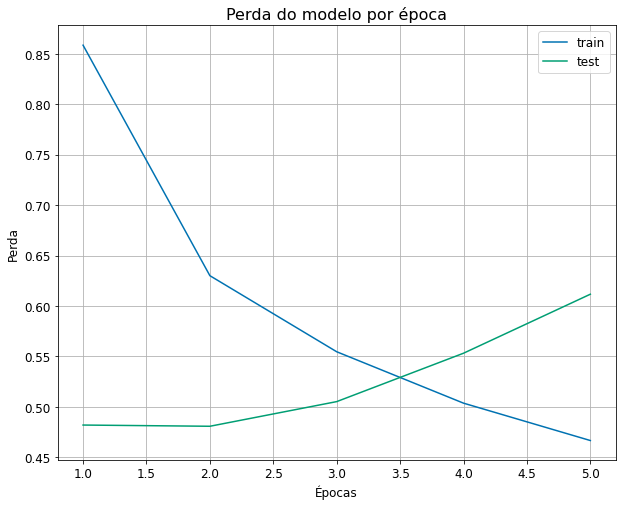

In [ ]:
# Plotando perda do modelo
interval = len(historico.history['loss'])
plt.plot(range(1,interval+1), historico.history['loss']), label='train')
plt.plot(range(1,interval+1), historico.history['val_loss']), label='test')
plt.title('Perda do modelo por época')
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.legend()
plt.grid()
plt.show();

### Teste: Acurácia do modelo

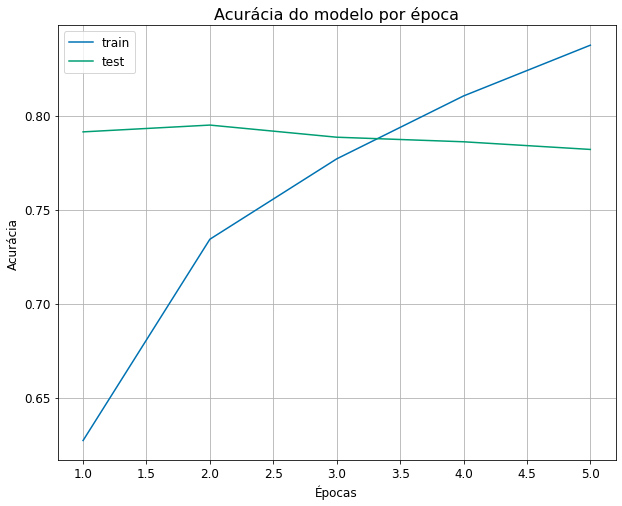

In [ ]:
# Plotando acuracia do modelo
plt.plot(range(1,interval+1), historico.history['accuracy'], label='train')
plt.plot(range(1,interval+1), historico.history['val_accuracy']), label='test')
plt.title('Acurácia do modelo por época')
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid()
plt.show();

### Teste: Matriz de confusão

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
      cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)



    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))   

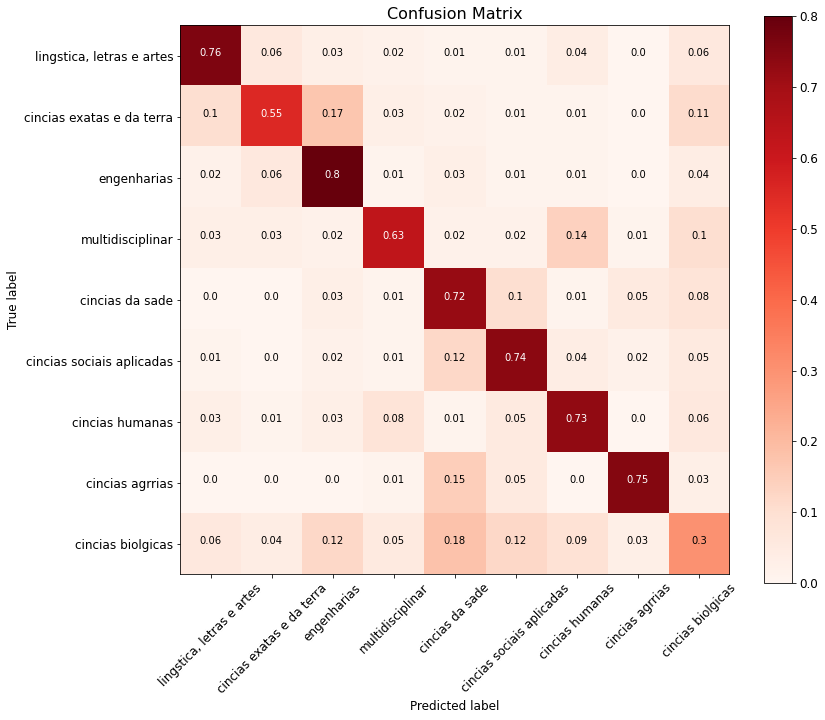

In [ ]:
cm_plot_labels = list(set(df['grande_area_descricao']))

# Recortando label
for i  in range(len(cm_plot_labels)):
  cm_plot_labels[i] = str(cm_plot_labels[i])

plot_confusion_matrix(cm=matrix, classes=cm_plot_labels, title='Confusion Matrix', normalize=True)

In [ ]:
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names= set(df['grande_area_descricao'])))

                           precision    recall  f1-score   support

lingstica, letras e artes       0.73      0.76      0.74      6101
cincias exatas e da terra       0.56      0.55      0.56      3764
              engenharias       0.75      0.80      0.77     10543
         multidisciplinar       0.65      0.63      0.64      4848
          cincias da sade       0.66      0.72      0.69     11089
cincias sociais aplicadas       0.70      0.74      0.72      9989
          cincias humanas       0.68      0.73      0.71      7186
          cincias agrrias       0.75      0.75      0.75      4063
        cincias biolgicas       0.43      0.30      0.35      9189

                 accuracy                           0.67     66772
                macro avg       0.66      0.66      0.66     66772
             weighted avg       0.66      0.67      0.66     66772



### Teste: predição de novas entradas

In [ ]:
novaSequencia = 'avaliao da segurana teraputica do formol em larvas e juvenis de pacams lophiosilusrus alexandri. formalin, toxicity, native fish, siluriform.'
seq = tokenizer.texts_to_sequences([sanitazeText(novaSequencia)])
padded = pad_sequences(seq, maxlen=maxSequence)
pred = model.predict(padded)
labels = list(set(df['grande_area_descricao']))
print(pred, labels[np.argmax(pred)])

[[9.9903679e-01 4.0066027e-04 1.2490311e-05 1.5207659e-05 2.7596916e-06
  4.7111939e-06 1.0895313e-05 8.3860059e-06 5.0816836e-04]] lingstica, letras e artes


# 4 - Conclusão
<p>Fora analisado desemprenho do modelo LSTM para a tarefa de classificação multi-classes, avaliando parâmetros de regularização e acurácia final, que fica em 84,2%  Pelos testes realizados com a variação das 5 épocas, fica claro a limitação quando a este tipo de ajuste, que não trousse grande diferenças nas duas últimas interações.</p>